# Communication system with FSK modulation/demodulation
## Modulate and demodulate frequency shift keying (FSK) signal from a random binary sequence

# Import libraries

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Initialize common parameters

In [147]:
np.random.seed(32)
n = 200 # number of bit
nb = 100 #number of samples per bit

Tb = 0.001 #bit period
br = 1/Tb #bit rate
f1 = 2*br #carrier frequency 1
f2 = 4*br #carrier frequency 2
t = Tb * np.arange(0, n, 1/nb)

## 1. Modulation

### 1.1 Generate and plot the carrier signal(s)

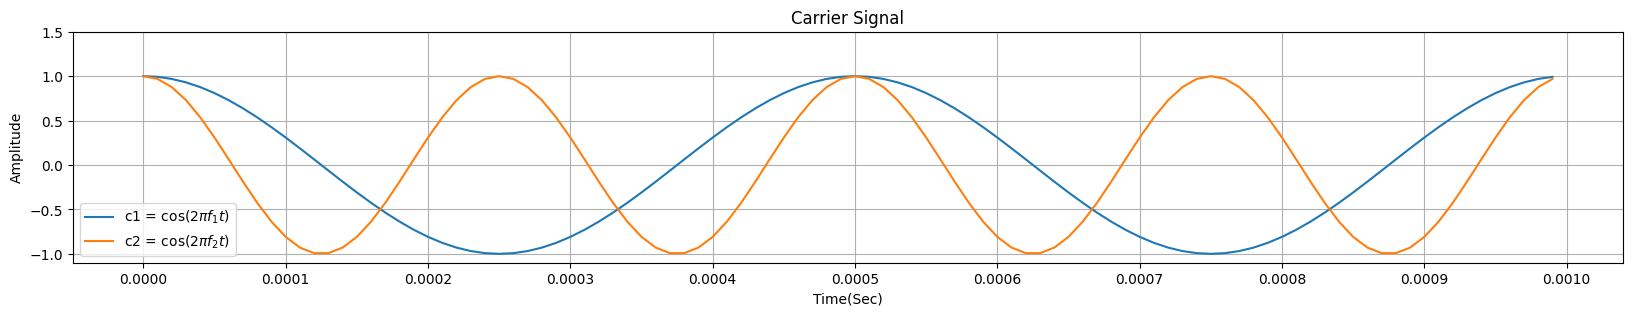

In [148]:
# define the carrier signal
c1 = np.cos(2*np.pi*f1*t)     # carrier signal for bit 0
c2 = np.cos(2*np.pi*f2*t)     # carrier signal for bit 1

# plot carrier signal per bit
plt.figure(figsize=(20,3))
t_  = Tb*np.arange(0,1,1/100)
plt.plot(t_,np.cos(2*np.pi*f1*t_))
plt.plot(t_,np.cos(2*np.pi*f2*t_))
plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')
plt.xticks(np.arange(0,Tb+Tb/10,Tb/10))
plt.yticks(np.arange(-1,2,0.5))
plt.grid(True)
plt.title('Carrier Signal')
plt.legend(['c1 = $\cos(2\pi f_1 t$)','c2 = $\cos(2\pi f_2 t)$'])
plt.show()

### 1.2 Generate and plot the binary data sequence

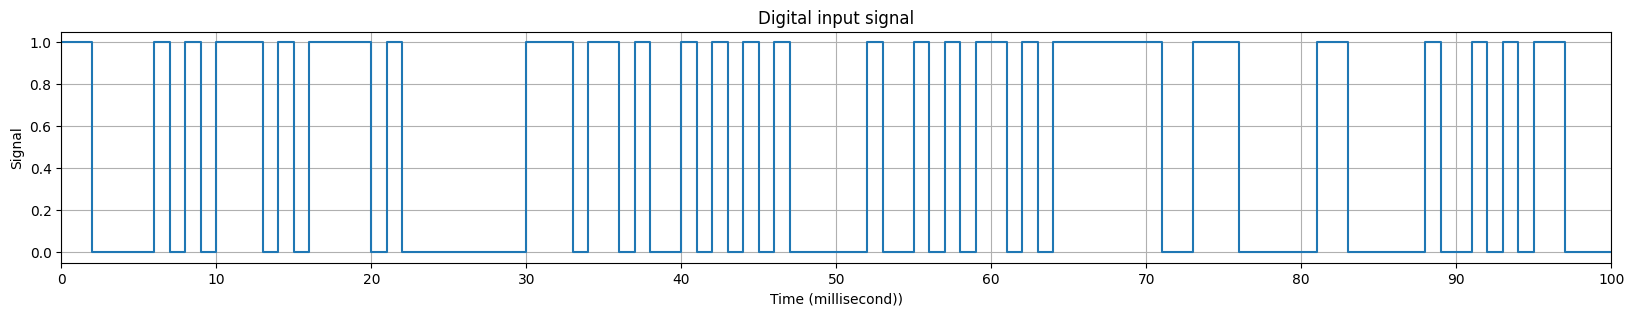

In [149]:
# generate the binary data sequence
binary_data_sequence = np.random.randint(2, size = n)
digit = np.empty(shape=0, dtype=int)
for i in range(0,n,1):
    if binary_data_sequence[i] == 1:
        digit = np.append(digit,np.ones(nb))
    else:
        digit = np.append(digit,np.zeros(nb))

# plot the binary data signal
plt.figure(figsize = (20, 3))   
plt.title('Digital input signal')
plt.xticks(1000*np.arange(0,Tb*n,Tb*10))
plt.xlim(0,100)
plt.xlabel('Time (millisecond))')
plt.ylabel('Signal')
plt.step(1000 * np.arange(0,Tb*n,Tb), binary_data_sequence)
plt.grid(True)
plt.margins(x=0.01, y=0.05)
plt.show()

### 1.3 Perform PSK modulation and plot the FSK modulated signal

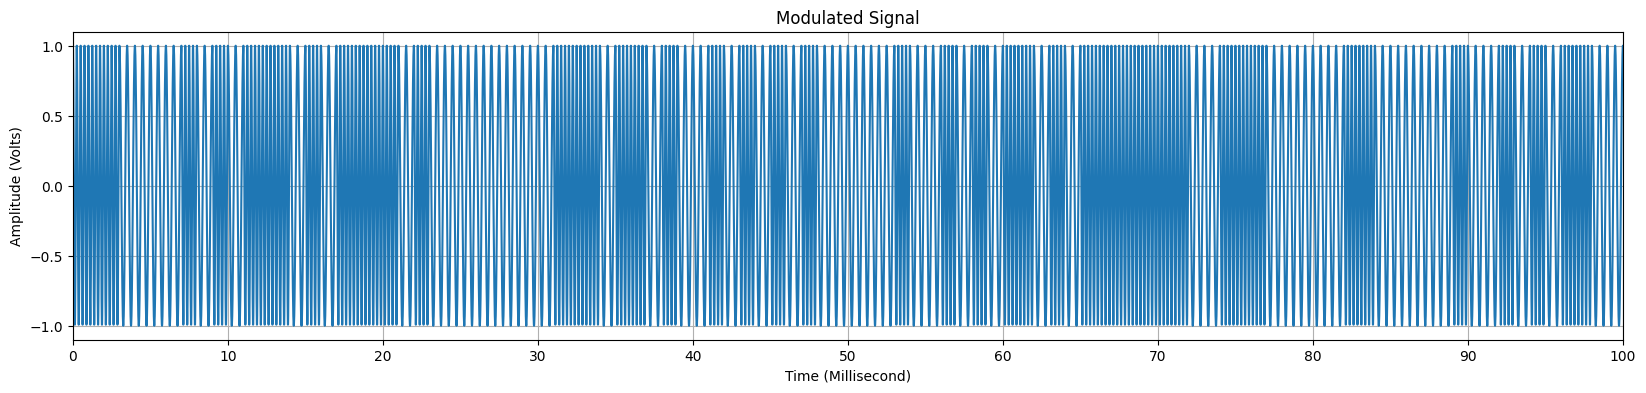

In [150]:
# perform FSK modulation
modulated_signal = np.where(digit == 0, c1, c2)

# plot the FSK modulated signal
plt.figure(figsize=(20,4))
plt.plot(1000 * t, modulated_signal)
plt.xlabel('Time (Millisecond)')
plt.ylabel('Amplitude (Volts)')
plt.xticks(1000*np.arange(0,Tb*n+Tb,Tb*10))
plt.xlim(0,100)
plt.yticks(np.arange(-1,1.5,0.5))
plt.grid(True)
plt.title('Modulated Signal')
plt.margins(x=0.01, y=0.05)
plt.show()

## 2. Demodulation
### 2.1 Correlate the FSK modulated signal with the carrier signal to generate decision variables

In [151]:
# demodulate the signal function 
def demodulate(input_modulated_signal):
    demodulated_signal=np.empty(shape=n, dtype=int) #empty array contain demodulated bit
    e1 = np.sum(c1[0:nb]**2) #energy of c1
    e2 = np.sum(c2[0:nb]**2) #energy of c2

    for i in range(0, n*nb, nb):
        I1 = np.trapz(input_modulated_signal[i:i + nb] * c1[0 : nb]) #calculate Convolution of FSK modulated signal and carrier signal c1
        I2 = np.trapz(input_modulated_signal[i:i + nb] * c2[ 0 : nb]) #calculate Convolution of FSK modulated signal and carrier signal c2
        #Correlate the FSK modulated signal with the carrier signal to generate decision variables.
        if I1 - 1/2*e1 > I2 - 1/2*e2:   
            demodulated_signal[np.floor(i/nb).astype('int')] = 0
        else:
            demodulated_signal[np.floor(i/nb).astype('int')] = 1
    return demodulated_signal

### 2.2 Obtain the demodulated binary data based on the decision variables

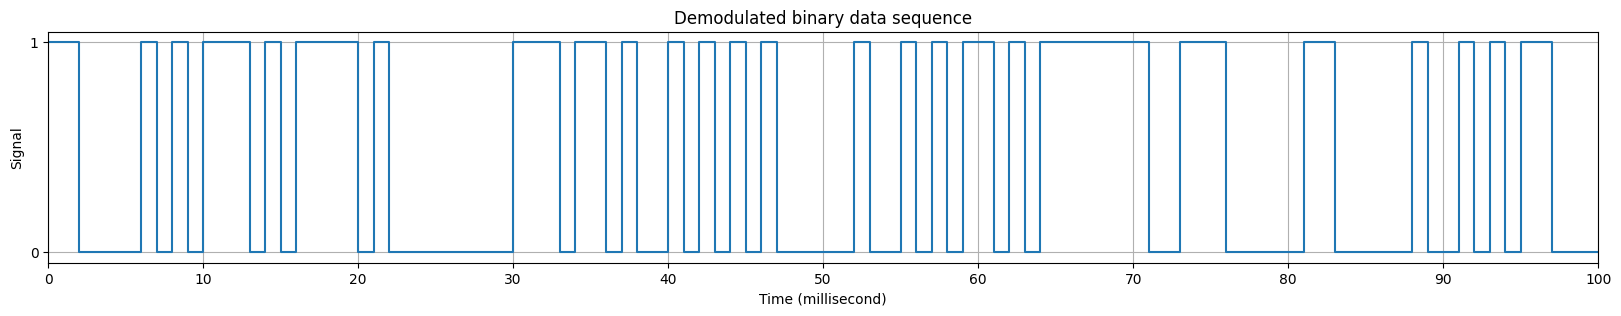

In [152]:
# demodulate the signal
demodulated_binary_data = demodulate(modulated_signal)

# plot the demodulated binary data sequence
plt.figure(figsize = (20, 3))
plt.title('Demodulated binary data sequence')
plt.xticks(1000*np.arange(0,Tb*n,Tb*10))
plt.xlim(0,100)
plt.xlabel('Time (millisecond)')
plt.ylabel('Signal')
plt.yticks([0,1])
plt.step(1000 * np.arange(0,Tb*n,Tb), demodulated_binary_data)
plt.margins(x=0.01, y=0.05)
plt.grid(True)

## 3. Investigate the FSK modulation/demodulation under the effects of Gaussian noise
### 3.1 Gaussian noise with zero mean and variance No/2 is added to the transmitted waveform as r(t) = s(t) + n(t)

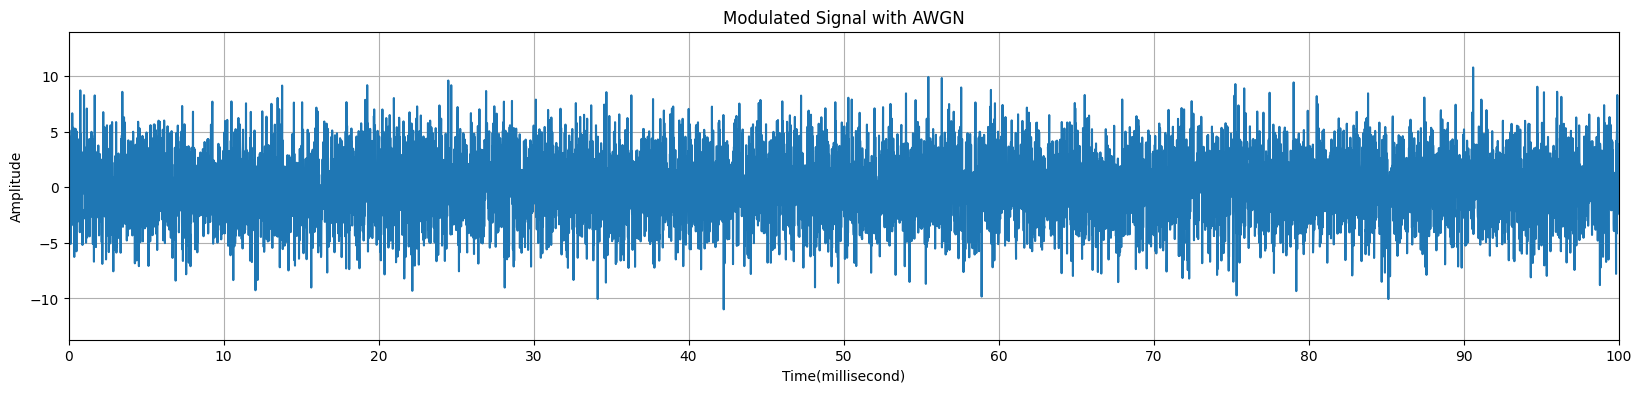

In [153]:
N0 = 16
std = np.sqrt(N0/2)

#FSK Modulation with AWGN
gaussian_noise = np.random.normal(0, std, len(modulated_signal))
awgn_mod = modulated_signal + gaussian_noise

# plot the modulated signal with AWGN
plt.figure(figsize=(20,4))
plt.plot(1000*t,awgn_mod)
plt.xlabel('Time(millisecond)')
plt.ylabel('Amplitude')
plt.xticks(1000*np.arange(0,Tb*n+Tb,Tb*10))
plt.xlim(0,100)
plt.grid(True)
plt.title('Modulated Signal with AWGN')
plt.margins(x=0.01, y=0.05)
plt.show()

### 3.2 FSK Demodulation with AWGN

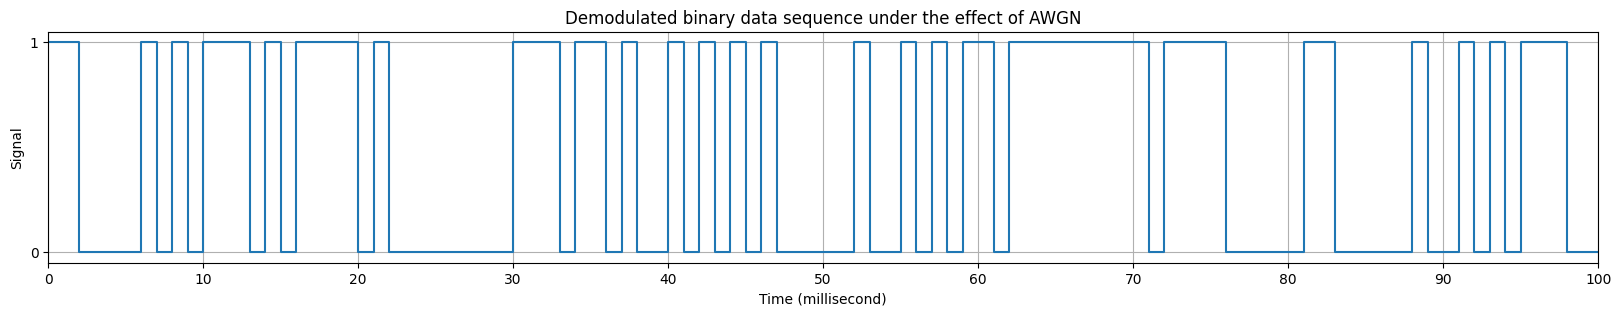

In [154]:
# demodulate the signal with AWGN
awgn_demod = demodulate(awgn_mod)

# plot the demodulated binary data sequence with effect of AWGN
plt.figure(figsize = (20, 3))
plt.title('Demodulated binary data sequence under the effect of AWGN')
plt.xticks(1000*np.arange(0,Tb*n,Tb*10))
plt.xlim(0,100)
plt.xlabel('Time (millisecond)')
plt.ylabel('Signal')
plt.yticks([0,1])
plt.step(1000*np.arange(0,Tb*n,Tb), awgn_demod)
plt.grid(True)
plt.margins(x=0.01, y=0.05)
plt.show()

### 3.3. BER simulation for N0 = 18

BER = 2.5%


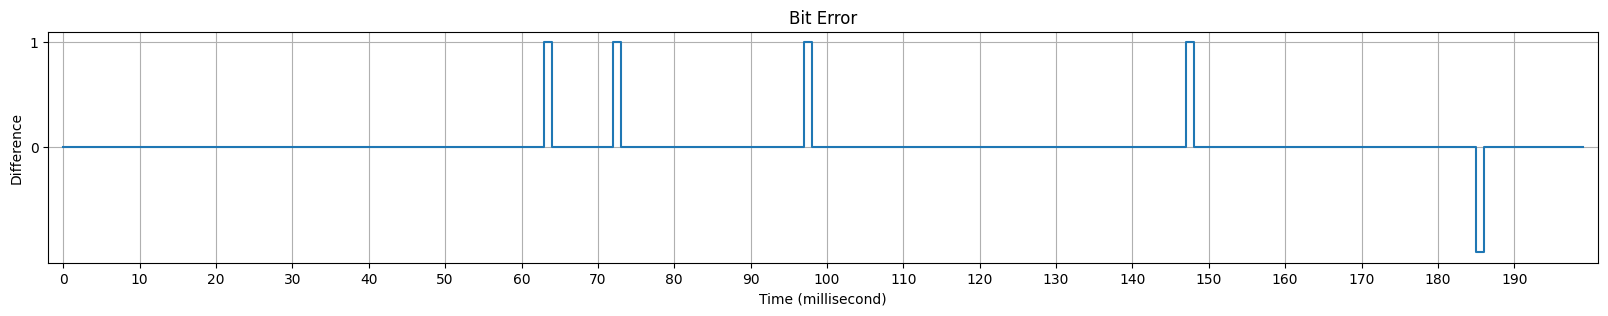

In [155]:
#Numerically compute the error probability 
Pb = np.count_nonzero(awgn_demod - binary_data_sequence) / len(binary_data_sequence)
print(f"BER = {Pb * 100}%")

plt.figure(figsize = (20, 3))
plt.title('Bit Error')
plt.xticks(1000*np.arange(0,Tb*n,Tb*10))
# plt.xlim(0,100)
plt.xlabel('Time (millisecond)')
plt.ylabel('Difference')
plt.yticks([0,1])
plt.step(1000*np.arange(0,Tb*n,Tb), awgn_demod-binary_data_sequence)
plt.grid(True)
plt.margins(x=0.01, y=0.05)
plt.show()

## 4. Theory: Derive the bit error probability of a Gaussian channel using the FSK modulation/demodulation

### 4.1 Generate BER simulation for 2-PSK

In [156]:
# Generate BER simulation for 2-FSK
E1 = np.trapz((c1**2)[0:nb])    # energy per bit for bit 0
E2 = np.trapz((c2**2)[0:nb])    # energy per bit for bit 1
Eb = 1/2 * (E1 + E2)            # energy per bit

#Calculate BER with different signal noise ratio 
snr_db = np.linspace(-20,12,110) #array of signal noise ratio in db form 
ber = np.zeros_like(snr_db).astype('double') #BER array 
sigma = np.zeros_like(snr_db).astype('double') #std
for i in range(len(snr_db)):
    sigma[i] = np.sqrt(1/2 * Eb / (10**(snr_db[i]/10))) # calculate std. Using snr_db = 10 * log10(Eb/N0)
    awgn_mod = modulated_signal + np.random.normal(0, sigma[i], len(modulated_signal)) #add AWGN
    awgn_demod = demodulate(awgn_mod) #demodulation
    ber[i] = np.count_nonzero(awgn_demod - binary_data_sequence) / len(binary_data_sequence)  #calculate BER

### 4.2 Plot the BER simulation and BER theory for 2-PSK

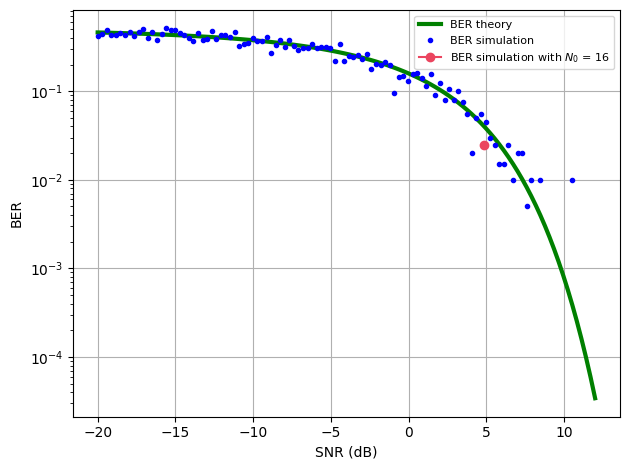

In [157]:
ber_theory = 1/2 * erfc(np.sqrt(10**(snr_db/10)/2)) # calculates the theoretical BER = 1/2 * erfc(1/sqrt(2) * sqrt(Eb/N0))
plt.semilogy(snr_db, ber_theory, 'g-', linewidth = 3)   # plot the theoretical BER
plt.semilogy(snr_db, ber, 'b.')     # plot the BER simulation results 
plt.plot(10*np.log10(Eb/N0), Pb, color = '#EB455F', marker = 'o') # plot the BER simulation results for AWGN with N0 = 16 (snr_db = 10 * log10(Eb/N0))
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(True)
plt.tight_layout()
plt.legend(['BER theory', 'BER simulation', 'BER simulation with $N_0$ = 16'], fontsize = 8)
plt.show()